In [1]:
import casadi as ca
import numpy as np
import os

os.chdir(os.path.dirname(os.getcwd()))
from utils import CarTrajectoryLinear, CarTrajectoryNonLinear, KF, plot_trajectory, StateSpaceModel

model = StateSpaceModel()
Q, R, A, H = model.get_linear_model()

c:\Users\wille\anaconda3\envs\dynopt\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
system = CarTrajectoryLinear(Q, R, A, H)
# system = CarTrajectoryNonLinear()
states, measurements = system.get_data()

states.shape, measurements.shape

((100, 4), (100, 2))

In [73]:
import casadi

opti = casadi.Opti()

# Define the symbolic variables
n_steps = states.shape[0]
n_states =  states.shape[1]
n_measurements = measurements.shape[1]

# make y casadi
casadi_measurements = casadi.MX(measurements)

# Define the decision variables
x = opti.variable(n_steps, n_states)
q = opti.variable(n_steps-1, n_states)
r = opti.variable(n_steps, n_measurements)

V = casadi.sumsqr(q) + casadi.sumsqr(r) # J = sum(r^2) + sum(q^2)

opti.subject_to(casadi.diff(x) == q) # x_{t+1} = x_t + q_t
opti.subject_to(casadi_measurements == x + r) # y_{t+1} = x_{t+1} + r_{t+1}

opti.minimize(V)

opti.solver('ipopt')

sol = opti.solve()

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1988
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      596

Total number of variables............................:      996
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      796
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.24e+01 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

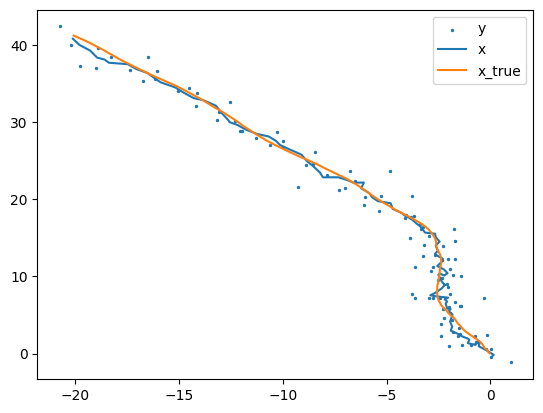

In [71]:
plt.scatter(measurements[:,0], measurements[:,1], s=2, label='y')
plt.plot(sol.value(x)[:,0], sol.value(x)[:,1], label='x')
plt.plot(states[:,0], states[:,1], label='x_true')


plt.legend()

In [76]:
sol.value(q).shape

(99, 4)

In [78]:
 np.diagflat(sol.value(q)[0])

array([[0.04479164, 0.        , 0.        , 0.        ],
       [0.        , 0.10592455, 0.        , 0.        ],
       [0.        , 0.        , 0.04479164, 0.        ],
       [0.        , 0.        , 0.        , 0.10592455]])

In [106]:
new_q = np.zeros((n_steps, n_states, n_states))

new_q[0] = np.identity(n_states)

for i in range(1, n_steps):
    new_q[i] = np.diagflat(sol.value(q)[i-1])

In [102]:
sol.value(q)[40]

array([0.21341015, 0.5489944 , 0.21341015, 0.5489944 ])

In [104]:
np.diagflat(sol.value(q)[40])

array([[0.21341015, 0.        , 0.        , 0.        ],
       [0.        , 0.5489944 , 0.        , 0.        ],
       [0.        , 0.        , 0.21341015, 0.        ],
       [0.        , 0.        , 0.        , 0.5489944 ]])

In [113]:
new_q[56]

array([[-0.2018338 ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.33919494,  0.        ,  0.        ],
       [ 0.        ,  0.        , -0.2018338 ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.33919494]])

: 

Text(0.5, 1.0, 'hey')

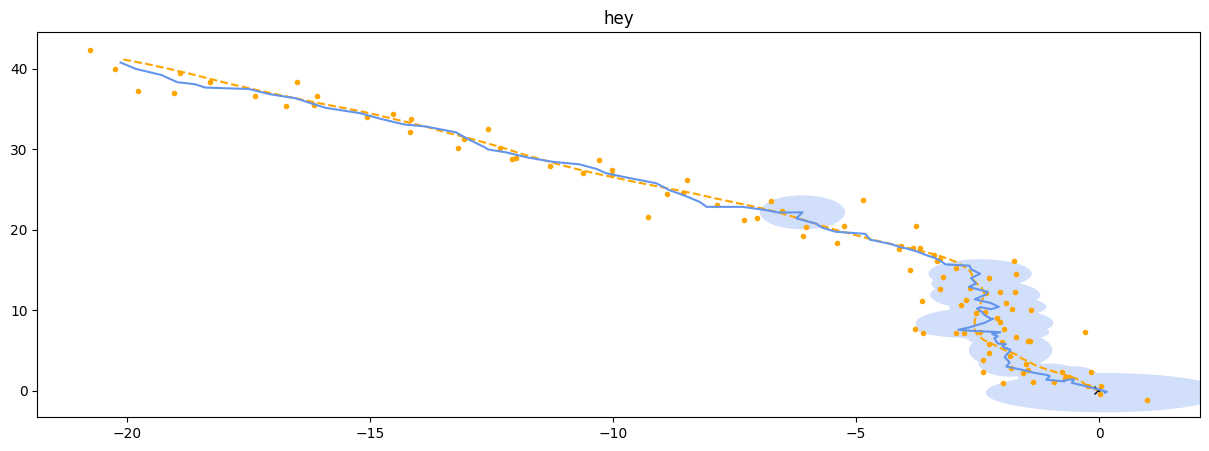

In [107]:
#Compare methods
fig, ax = plt.subplots(1, 1, figsize=(15, 5), sharey=True)

ax.plot(states[0, 0], states[0, 1], 'x', color='k', label="Start")
ax.plot(states[:, 0], states[:, 1], '--', color='orange', label="True trajectory")
ax.plot(measurements[:, 0], measurements[:, 1], '.', color='orange', label="Noisy observations")

plot_trajectory(ax, sol.value(x), new_q, label="hey")
ax.set_title("hey")

ValueError: x and y must have same first dimension, but have shapes (10,) and (100, 4)

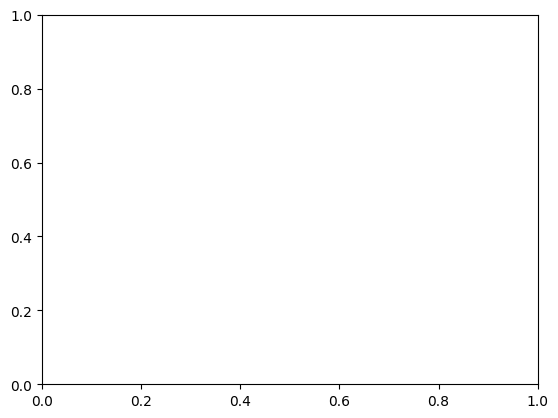

In [56]:
plot_trajectory(ax[0], state_estimates, cov_estimates, label="UKF")
ax[0].set_title("KF")


# Show the MSE on the plot in upper right corner
ax[0].text(0.95, 0.95, "MSE: {:.2f}".format(np.mean((states[:, :2] - state_estimates[:, :2])**2)),
           horizontalalignment='right', verticalalignment='top', transform=ax[0].transAxes)
ax[1].text(0.95, 0.95, "MSE: {:.2f}".format(np.mean((states[:, :2] - state_estimates_smoothed[:, :2])**2)),
           horizontalalignment='right', verticalalignment='top', transform=ax[1].transAxes)

plt.show()

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      599
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      199

Total number of variables............................:      399
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      201
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 6.28e+00 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

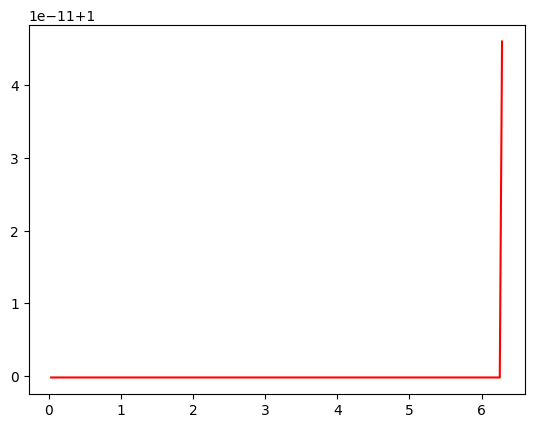

In [7]:
## Reproduce the optimal solution with casadi
import casadi
import pylab
import matplotlib.pyplot as plt

U = 1
w0 = 0

opti = casadi.Opti()
N = 200
t = np.linspace(0,2*np.pi/U,N)
dt = t[1] - t[0]

xc = opti.variable(N)
uc = opti.variable(N-1)

def wind(x):
     return(w0 * np.cos(x))

wc = wind(0.5*xc[1:] + 0.5*xc[:-1])

V = casadi.sum1((uc+wc)**2 * uc * dt)

opti.minimize(V)

opti.subject_to(casadi.diff(xc)== uc*dt)
opti.subject_to(xc[0]==0)
opti.subject_to(xc[-1]==2*np.pi)

opti.solver('ipopt')

sol = opti.solve()

plt.plot(sol.value(xc[1:]),sol.value(uc),'r-')
plt.show()